## Analysis of COVID-19 Cases in Monroe, NY 

This project aims at analysing the rate of infection of COVID-19 in Monroe County, NY, over a period of February 2020 to October 2021. 
We use the following datasets:
* [U.S. State and Territorial Public Mask Mandates From April 10, 2020 through August 15, 2021 by County by Day](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i)
* [COVID-19 data from John Hopkins University](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv)
* [Mask-Wearing Survey Data](https://github.com/nytimes/covid-19-data/tree/master/mask-use)


### Importing Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
import matplotlib.patches as mpatches

### Data Collection and Transformation

In [2]:
raw_us_confirmed_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
raw_us_deaths = pd.read_csv("RAW_us_deaths.csv")


In [3]:
raw_us_confirmed_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18480,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65895,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6926,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7560,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17286,17320,17320,17320,17320


In [4]:
raw_monroe_cases = raw_us_confirmed_cases[(raw_us_confirmed_cases["Province_State"] == "New York") & (raw_us_confirmed_cases["Admin2"] == "Monroe")]
raw_monroe_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22
1929,New York,Monroe,84036055,US,USA,840,36055.0,US,43.146389,-77.693229,...,181537,181645,181736,181796,181878,181985,182127,182244,182362,182431


In [5]:
#Extracting the FIPS code for assigned county - Monroe County
monroe_fips = raw_monroe_cases["FIPS"].values[0]
monroe_fips

36055.0

We perform some transformations on the data.
We need the csv file RAW_us_confirmed_cases to get the daily number of cases (assuming they are the active cases on that day).
We then transpose to convert the date columns to rows, and convert the date field to datetime.
We add a new column - confirmed_rate - which is the daily rate of confirmed cases in Monroe County.

In [6]:
monroe_confirmed_by_date = raw_monroe_cases[raw_monroe_cases.columns[12:]]
monroe_confirmed_by_date = pd.DataFrame(monroe_confirmed_by_date.iloc[0])
monroe_confirmed_by_date = monroe_confirmed_by_date.reset_index()
monroe_confirmed_by_date.columns = ["date", "confirmed_cases"]
monroe_confirmed_by_date["date"] = pd.to_datetime(monroe_confirmed_by_date["date"])
monroe_confirmed_by_date["confirmed_rate"] = pd.Series(np.gradient(monroe_confirmed_by_date["confirmed_cases"]), monroe_confirmed_by_date["date"], name='confirmed_cases_rate').values


In [7]:
#Getting the mask mandate data for Monroe County

monroe_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "NY") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Monroe County')]
monroe_mask_mandates_april_2020_aug_2021.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
493434,NY,Monroe County,36,55,4/10/2020,2,NaN,NaN,NaN,NaN
493435,NY,Monroe County,36,55,4/11/2020,2,NaN,NaN,NaN,NaN
493436,NY,Monroe County,36,55,4/12/2020,2,NaN,NaN,NaN,NaN
493437,NY,Monroe County,36,55,4/13/2020,2,NaN,NaN,NaN,NaN
493438,NY,Monroe County,36,55,4/14/2020,2,NaN,NaN,NaN,NaN


In [8]:
# Extracting data from Feb 2020 to October 2021
monroe_confirmed_by_date_extract = monroe_confirmed_by_date.iloc[9:618]

In [10]:
# Creating a merged dataframe with number of cases and mask mandate data
monroe_mask_mandates_april_2020_aug_2021["date"] =  pd.to_datetime(monroe_mask_mandates_april_2020_aug_2021["date"])
cases_mandate_merge = pd.merge(monroe_confirmed_by_date_extract, monroe_mask_mandates_april_2020_aug_2021, on="date", how='left')


<ipython-input-10-cab205aef57a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monroe_mask_mandates_april_2020_aug_2021["date"] =  pd.to_datetime(monroe_mask_mandates_april_2020_aug_2021["date"])


In [56]:
cases_mandate_merge["Face_Masks_Required_in_Public"] = cases_mandate_merge["Face_Masks_Required_in_Public"].fillna("No Data")
cases_mandate_merge.head()

,date,confirmed_cases,confirmed_rate,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,rate_of_infection,rate_of_infection_derivative
0,2020-02-01,0,0.0,NaN,NaN,NaN,NaN,NaN,No Data,NaN,NaN,NaN,0.0,NaN
1,2020-02-02,0,0.0,NaN,NaN,NaN,NaN,NaN,No Data,NaN,NaN,NaN,0.0,0.0
2,2020-02-03,0,0.0,NaN,NaN,NaN,NaN,NaN,No Data,NaN,NaN,NaN,0.0,0.0
3,2020-02-04,0,0.0,NaN,NaN,NaN,NaN,NaN,No Data,NaN,NaN,NaN,0.0,0.0
4,2020-02-05,0,0.0,NaN,NaN,NaN,NaN,NaN,No Data,NaN,NaN,NaN,0.0,0.0


## Visualizations

In [12]:
colors = {'Yes':'tab:purple', 'No':'tab:red', 'No Data':'tab:green'}
green_patch = mpatches.Patch(color='green', label='Unknown Masking Policy')
purple_patch = mpatches.Patch(color='purple', label='Mask Mandate in Effect')
red_patch = mpatches.Patch(color='red', label='No Mask Mandate in Effect')

### Plotting Daily Confirmed (assumed active) Cases and the Mask Mandate in effect at the time

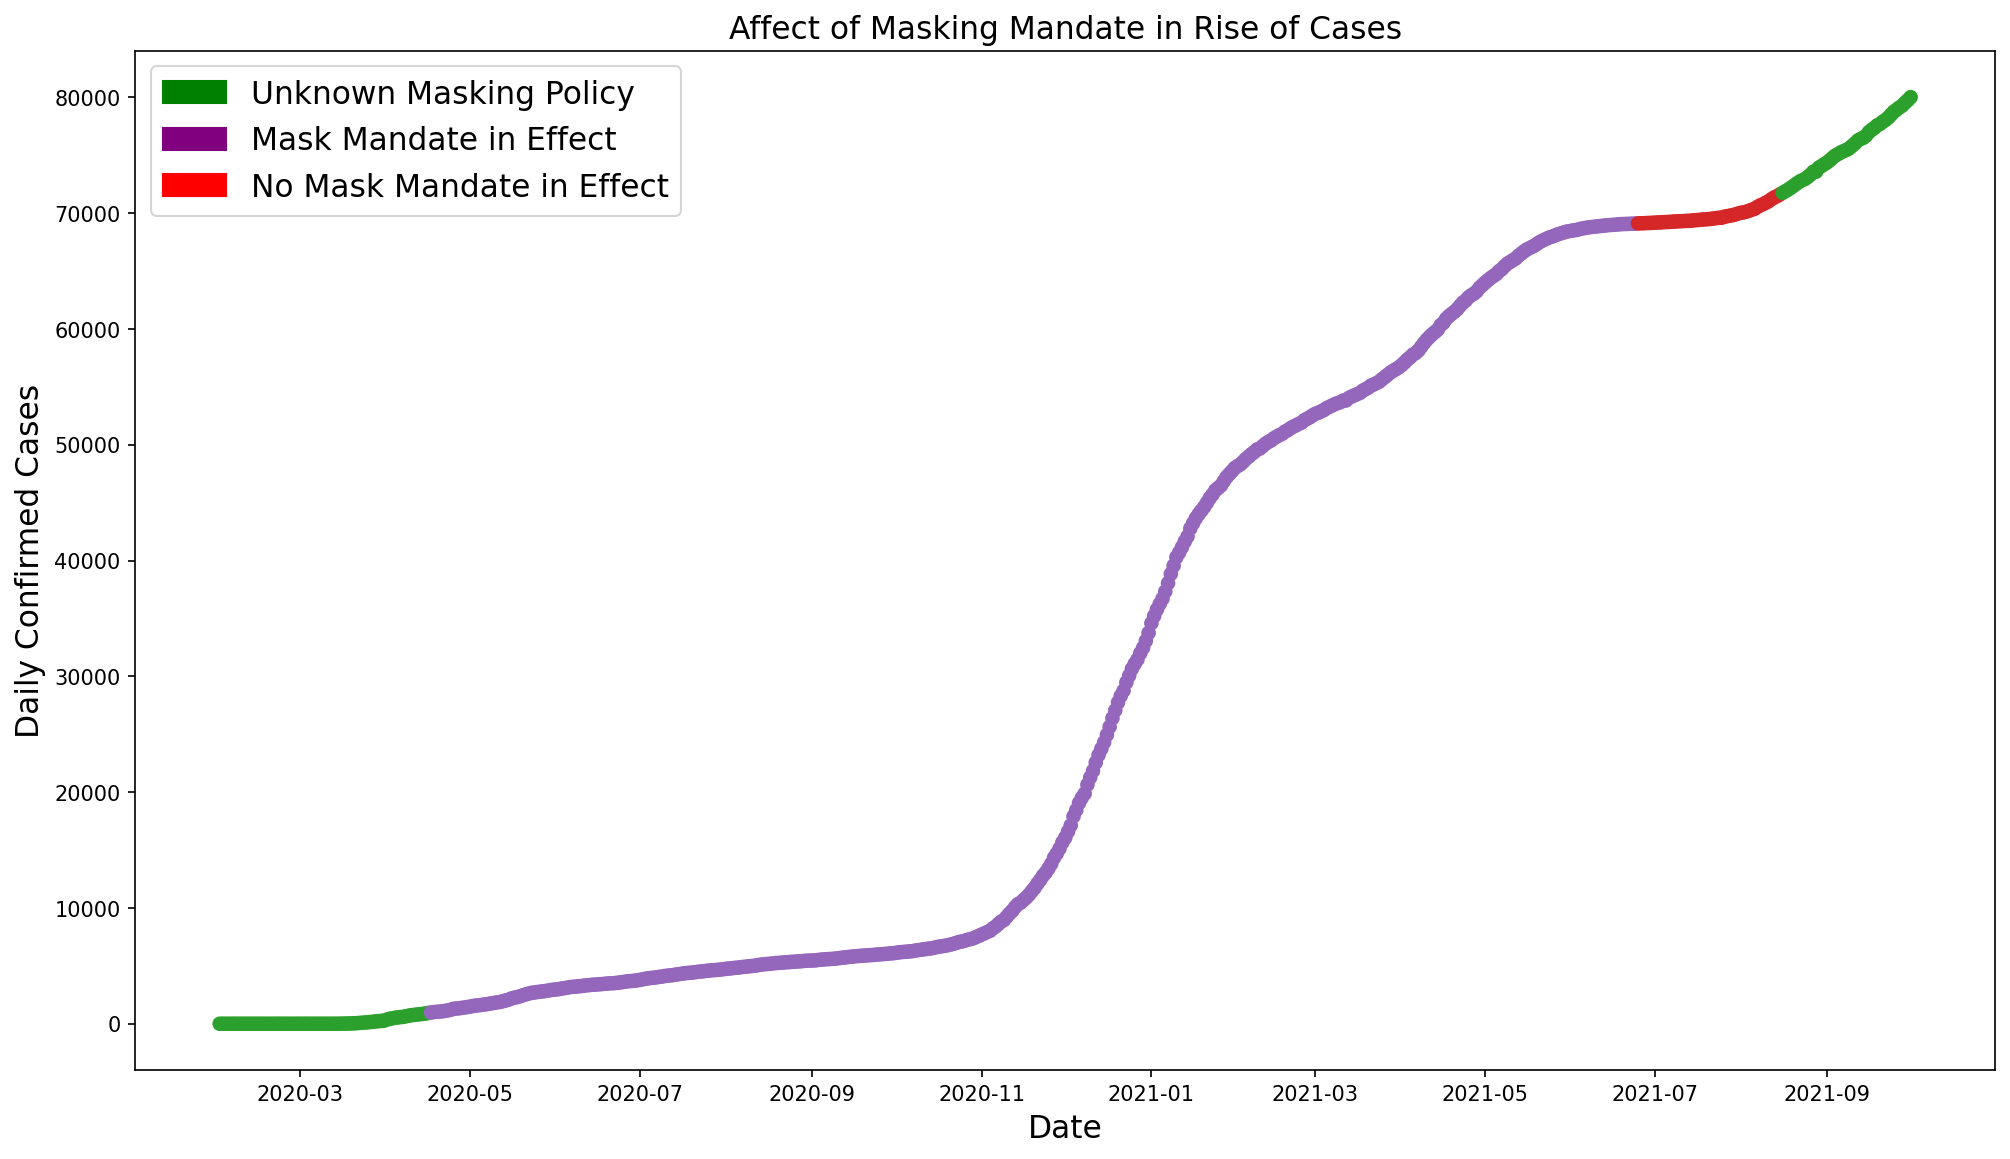

In [50]:
plt.figure(figsize=(16,9), dpi=150)
df_plot = plt.scatter(cases_mandate_merge['date'], cases_mandate_merge['confirmed_cases'], c=cases_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.xlabel('Date', fontdict={'fontsize': 15})
plt.ylabel('Daily Confirmed Cases', fontdict={'fontsize': 15})
plt.title('Affect of Masking Mandate in Rise of Cases', fontdict={'fontsize': 15})

plt.legend(handles=[green_patch, purple_patch, red_patch], prop={'size': 15}, loc=2)


### Plotting Daily New (assumed change in case count from previous day) Cases and the Mask Mandate in effect at the time along with the change points in the graph

Text(0.5, 0.06, 'Daily change in confirmed cases from Feb 2021 to Oct 2022 along with masking policies and change points showing effects of those policies')

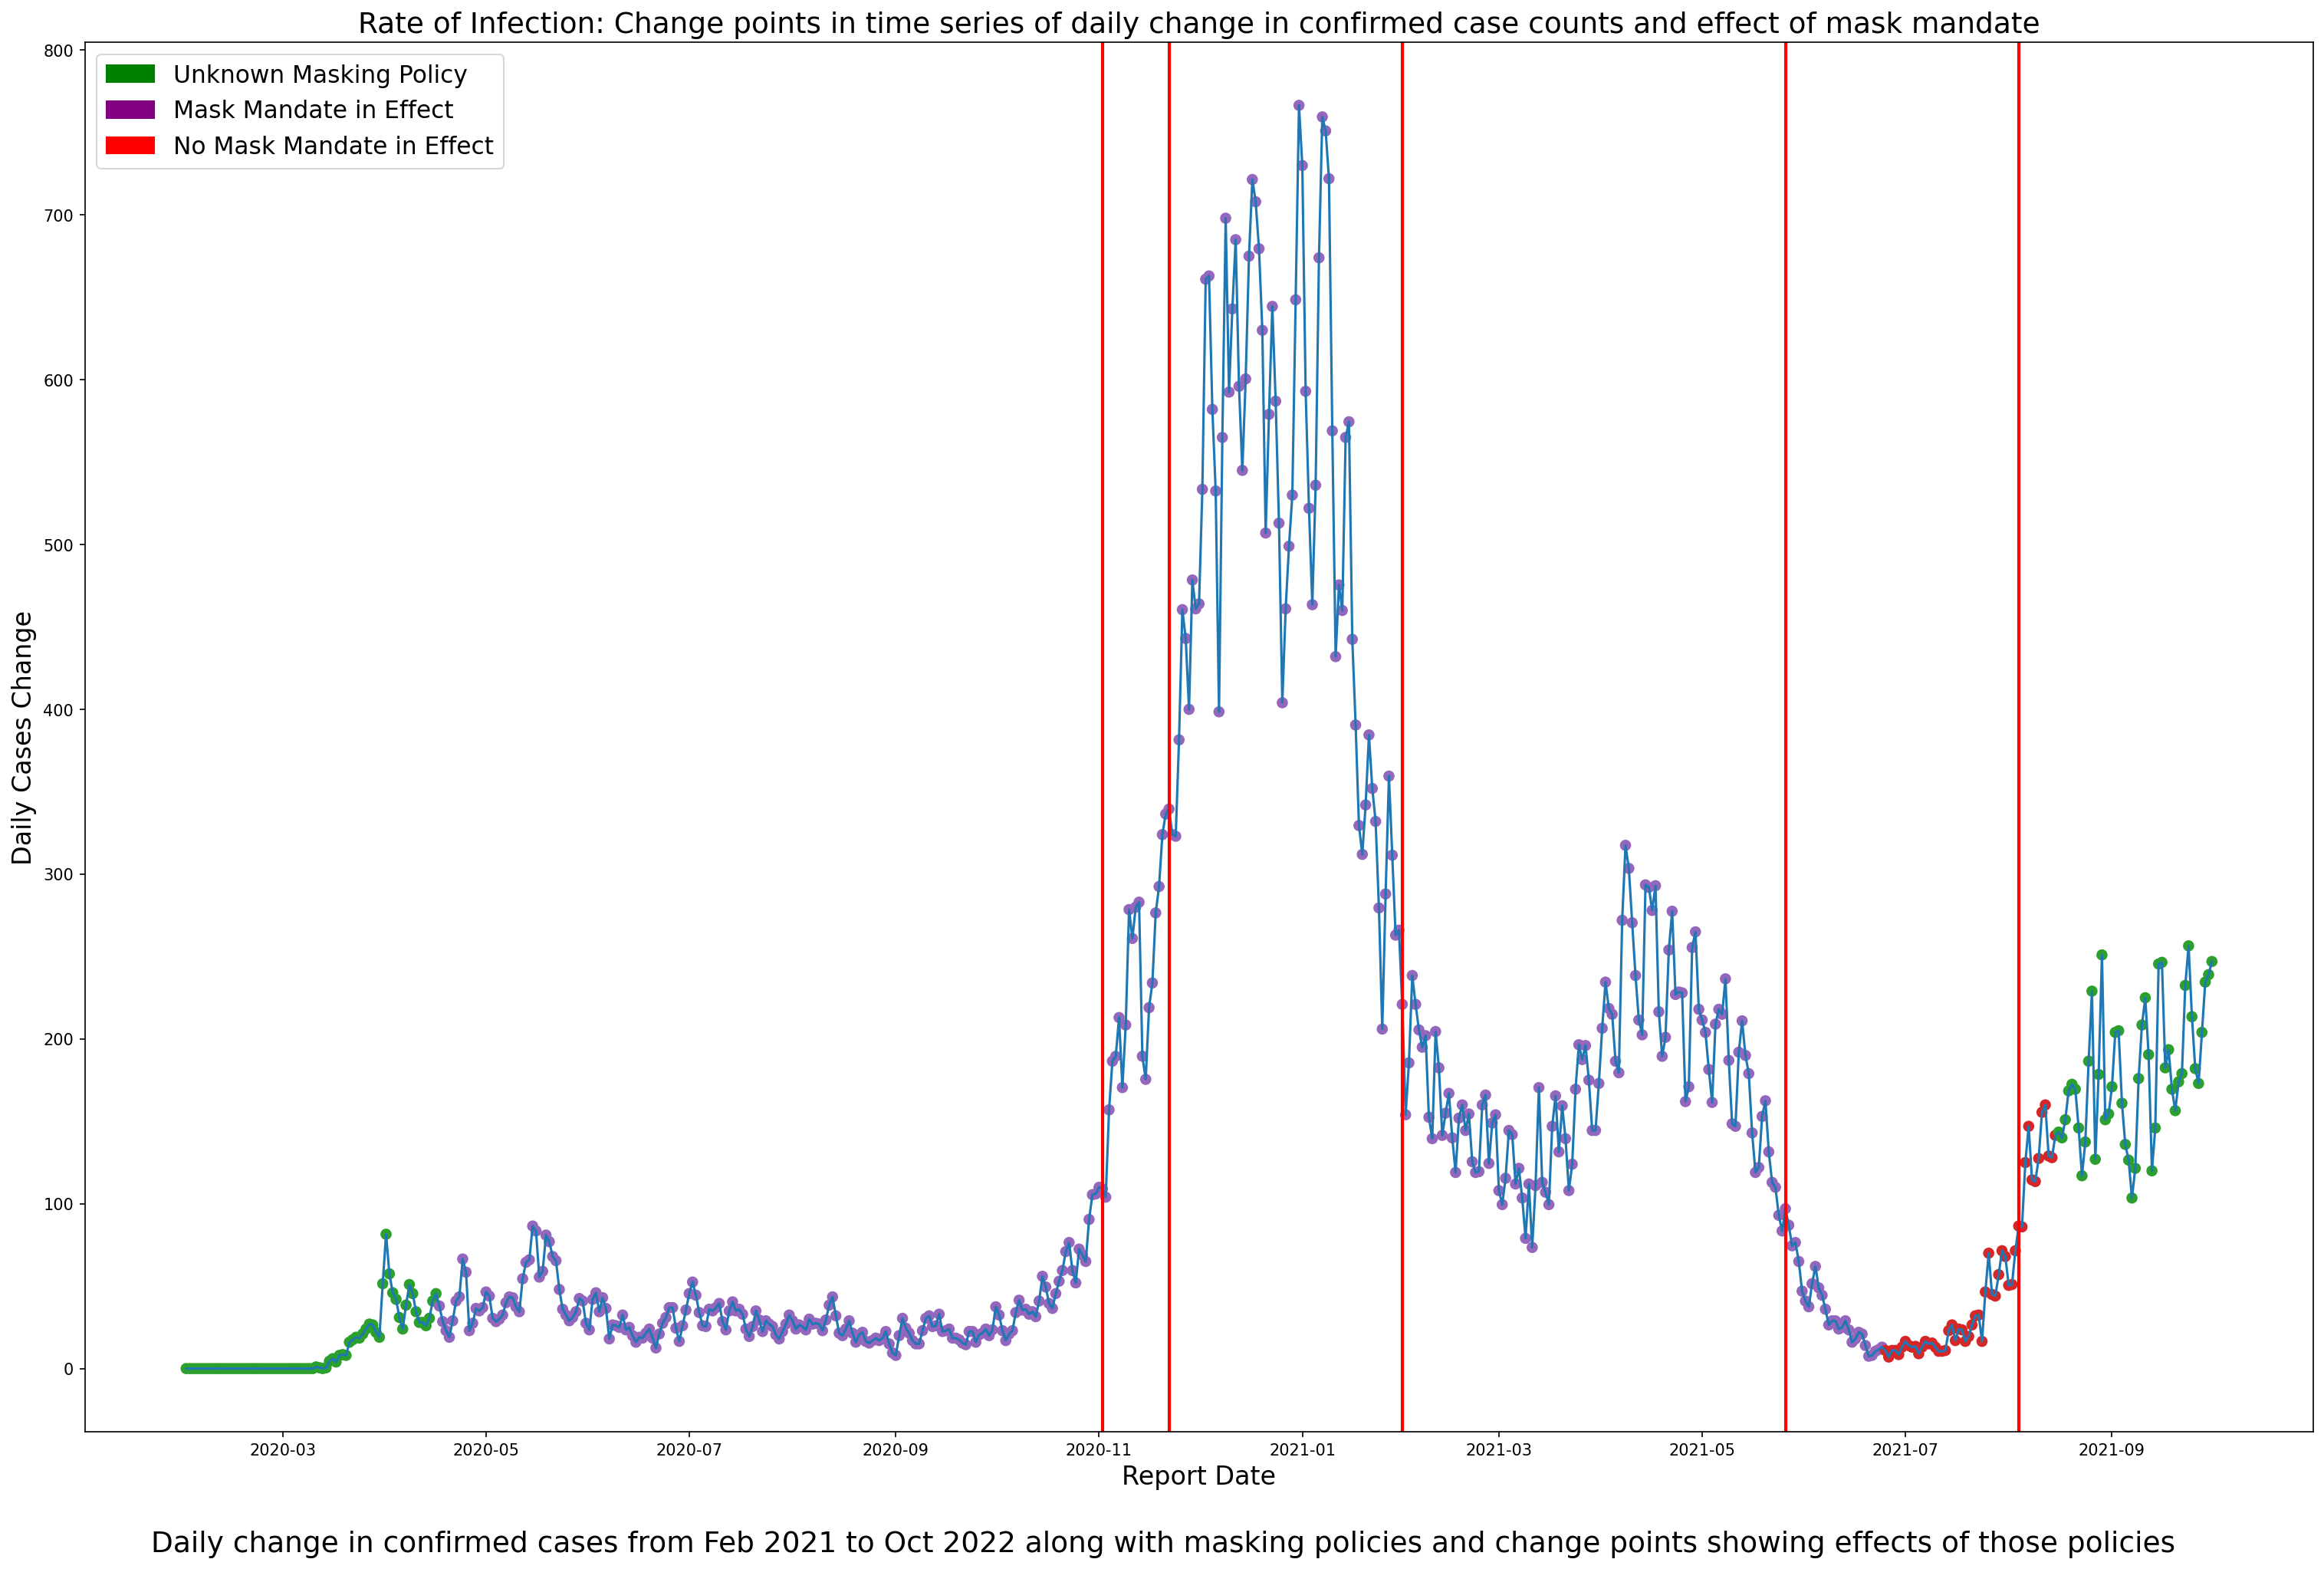

In [75]:
#Using rupture for change point analysis
data = np.array(monroe_confirmed_by_date_extract['confirmed_rate'])
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen = 10)
tmp = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]
change_location_index = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]

plt.figure(figsize=(25,16), dpi = 150)
plt.scatter(cases_mandate_merge['date'], cases_mandate_merge['confirmed_rate'], c=cases_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.plot(cases_mandate_merge['date'], cases_mandate_merge['confirmed_rate'])

for x in change_location_index['date']:
    plt.axvline(x, lw=2, color='red')

plt.title('Rate of Infection: Change points in time series of daily change in confirmed case counts and effect of mask mandate', fontdict={'fontsize': 18})
plt.xlabel('Report Date', fontdict={'fontsize': 16})
plt.ylabel('Daily Cases Change', fontdict={'fontsize': 16})

plt.legend(handles=[green_patch, purple_patch, red_patch], prop={'size': 15}, loc=2)

txt="Daily change in confirmed cases from Feb 2021 to Oct 2022 along with masking policies and change points showing effects of those policies"
plt.figtext(0.5, 0.06, txt, wrap=True, horizontalalignment='center', fontsize=18)



### Rate of Infection

We define Rate of Infection as change in daily case count. This graph is plotted above along with change points and color coded to show the effects of mask mandate.

We can also define rate of infection as the average number of newly confirmed cases in the last 7 days per 100,000 residents based on this [link](https://covid19.gachd.org/daily-case-rate-per-100000/#:~:text=To%20calculate%20the%20daily%20rate,compare%20larger%20and%20smaller%20counties) 

In [59]:
total_population = 755160
monroe_confirmed_by_date_extract['rate_of_infection'] = ((monroe_confirmed_by_date_extract['confirmed_rate'] - monroe_confirmed_by_date_extract.shift(periods = 1)['confirmed_rate'])/total_population)*100000
monroe_confirmed_by_date_extract['rate_of_infection'].fillna(0.0, inplace=True)
cases_mandate_merge['rate_of_infection'] = ((cases_mandate_merge['confirmed_rate'] - cases_mandate_merge.shift(periods = 1)['confirmed_rate'])/total_population)*100000
cases_mandate_merge['rate_of_infection'].fillna(0.0, inplace=True)
monroe_confirmed_by_date_extract.head()

<ipython-input-59-629600599bde>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monroe_confirmed_by_date_extract['rate_of_infection'] = ((monroe_confirmed_by_date_extract['confirmed_rate'] - monroe_confirmed_by_date_extract.shift(periods = 1)['confirmed_rate'])/total_population)*100000
/Users/aqua/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,date,confirmed_cases,confirmed_rate,rate_of_infection,rate_of_infection_derivative
9,2020-02-01,0,0.0,0.0,NaN
10,2020-02-02,0,0.0,0.0,0.0
11,2020-02-03,0,0.0,0.0,0.0
12,2020-02-04,0,0.0,0.0,0.0
13,2020-02-05,0,0.0,0.0,0.0


In [64]:
#Taking total population from the county assignment sheet, and calculating the average number of newly confirmed cases in the last 7 days.
monroe_confirmed_by_date_extract['rate_of_infection_new'] = (monroe_confirmed_by_date_extract['confirmed_rate'].rolling(7).mean()/total_population)*100000
monroe_confirmed_by_date_extract['rate_of_infection_new'].fillna(0.0, inplace=True)
cases_mandate_merge['rate_of_infection_new'] = (cases_mandate_merge['confirmed_rate'].rolling(7).mean()/total_population)*100000
cases_mandate_merge['rate_of_infection_new'].fillna(0.0, inplace=True)
monroe_confirmed_by_date_extract

<ipython-input-64-66b6f6d1f274>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monroe_confirmed_by_date_extract['rate_of_infection_new'] = (monroe_confirmed_by_date_extract['confirmed_rate'].rolling(7).mean()/total_population)*100000
/Users/aqua/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,date,confirmed_cases,confirmed_rate,rate_of_infection,rate_of_infection_derivative,rate_of_infection_new
9,2020-02-01,0,0.0,0.000000,NaN,0.000000
10,2020-02-02,0,0.0,0.000000,0.000000,0.000000
11,2020-02-03,0,0.0,0.000000,0.000000,0.000000
12,2020-02-04,0,0.0,0.000000,0.000000,0.000000
13,2020-02-05,0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
613,2021-09-27,79131,173.0,-1.191800,2.979501,26.683087
614,2021-09-28,79289,204.0,4.105090,5.296891,27.250611
615,2021-09-29,79539,234.5,4.038879,-0.066211,28.300530
616,2021-09-30,79758,239.0,0.595900,-3.442979,28.423494


Text(0.5, 0.05, 'Effect of Mask Mandate on Rate of Infection from Feb 2021 to Oct 2022 and change points showing effects of those policies')

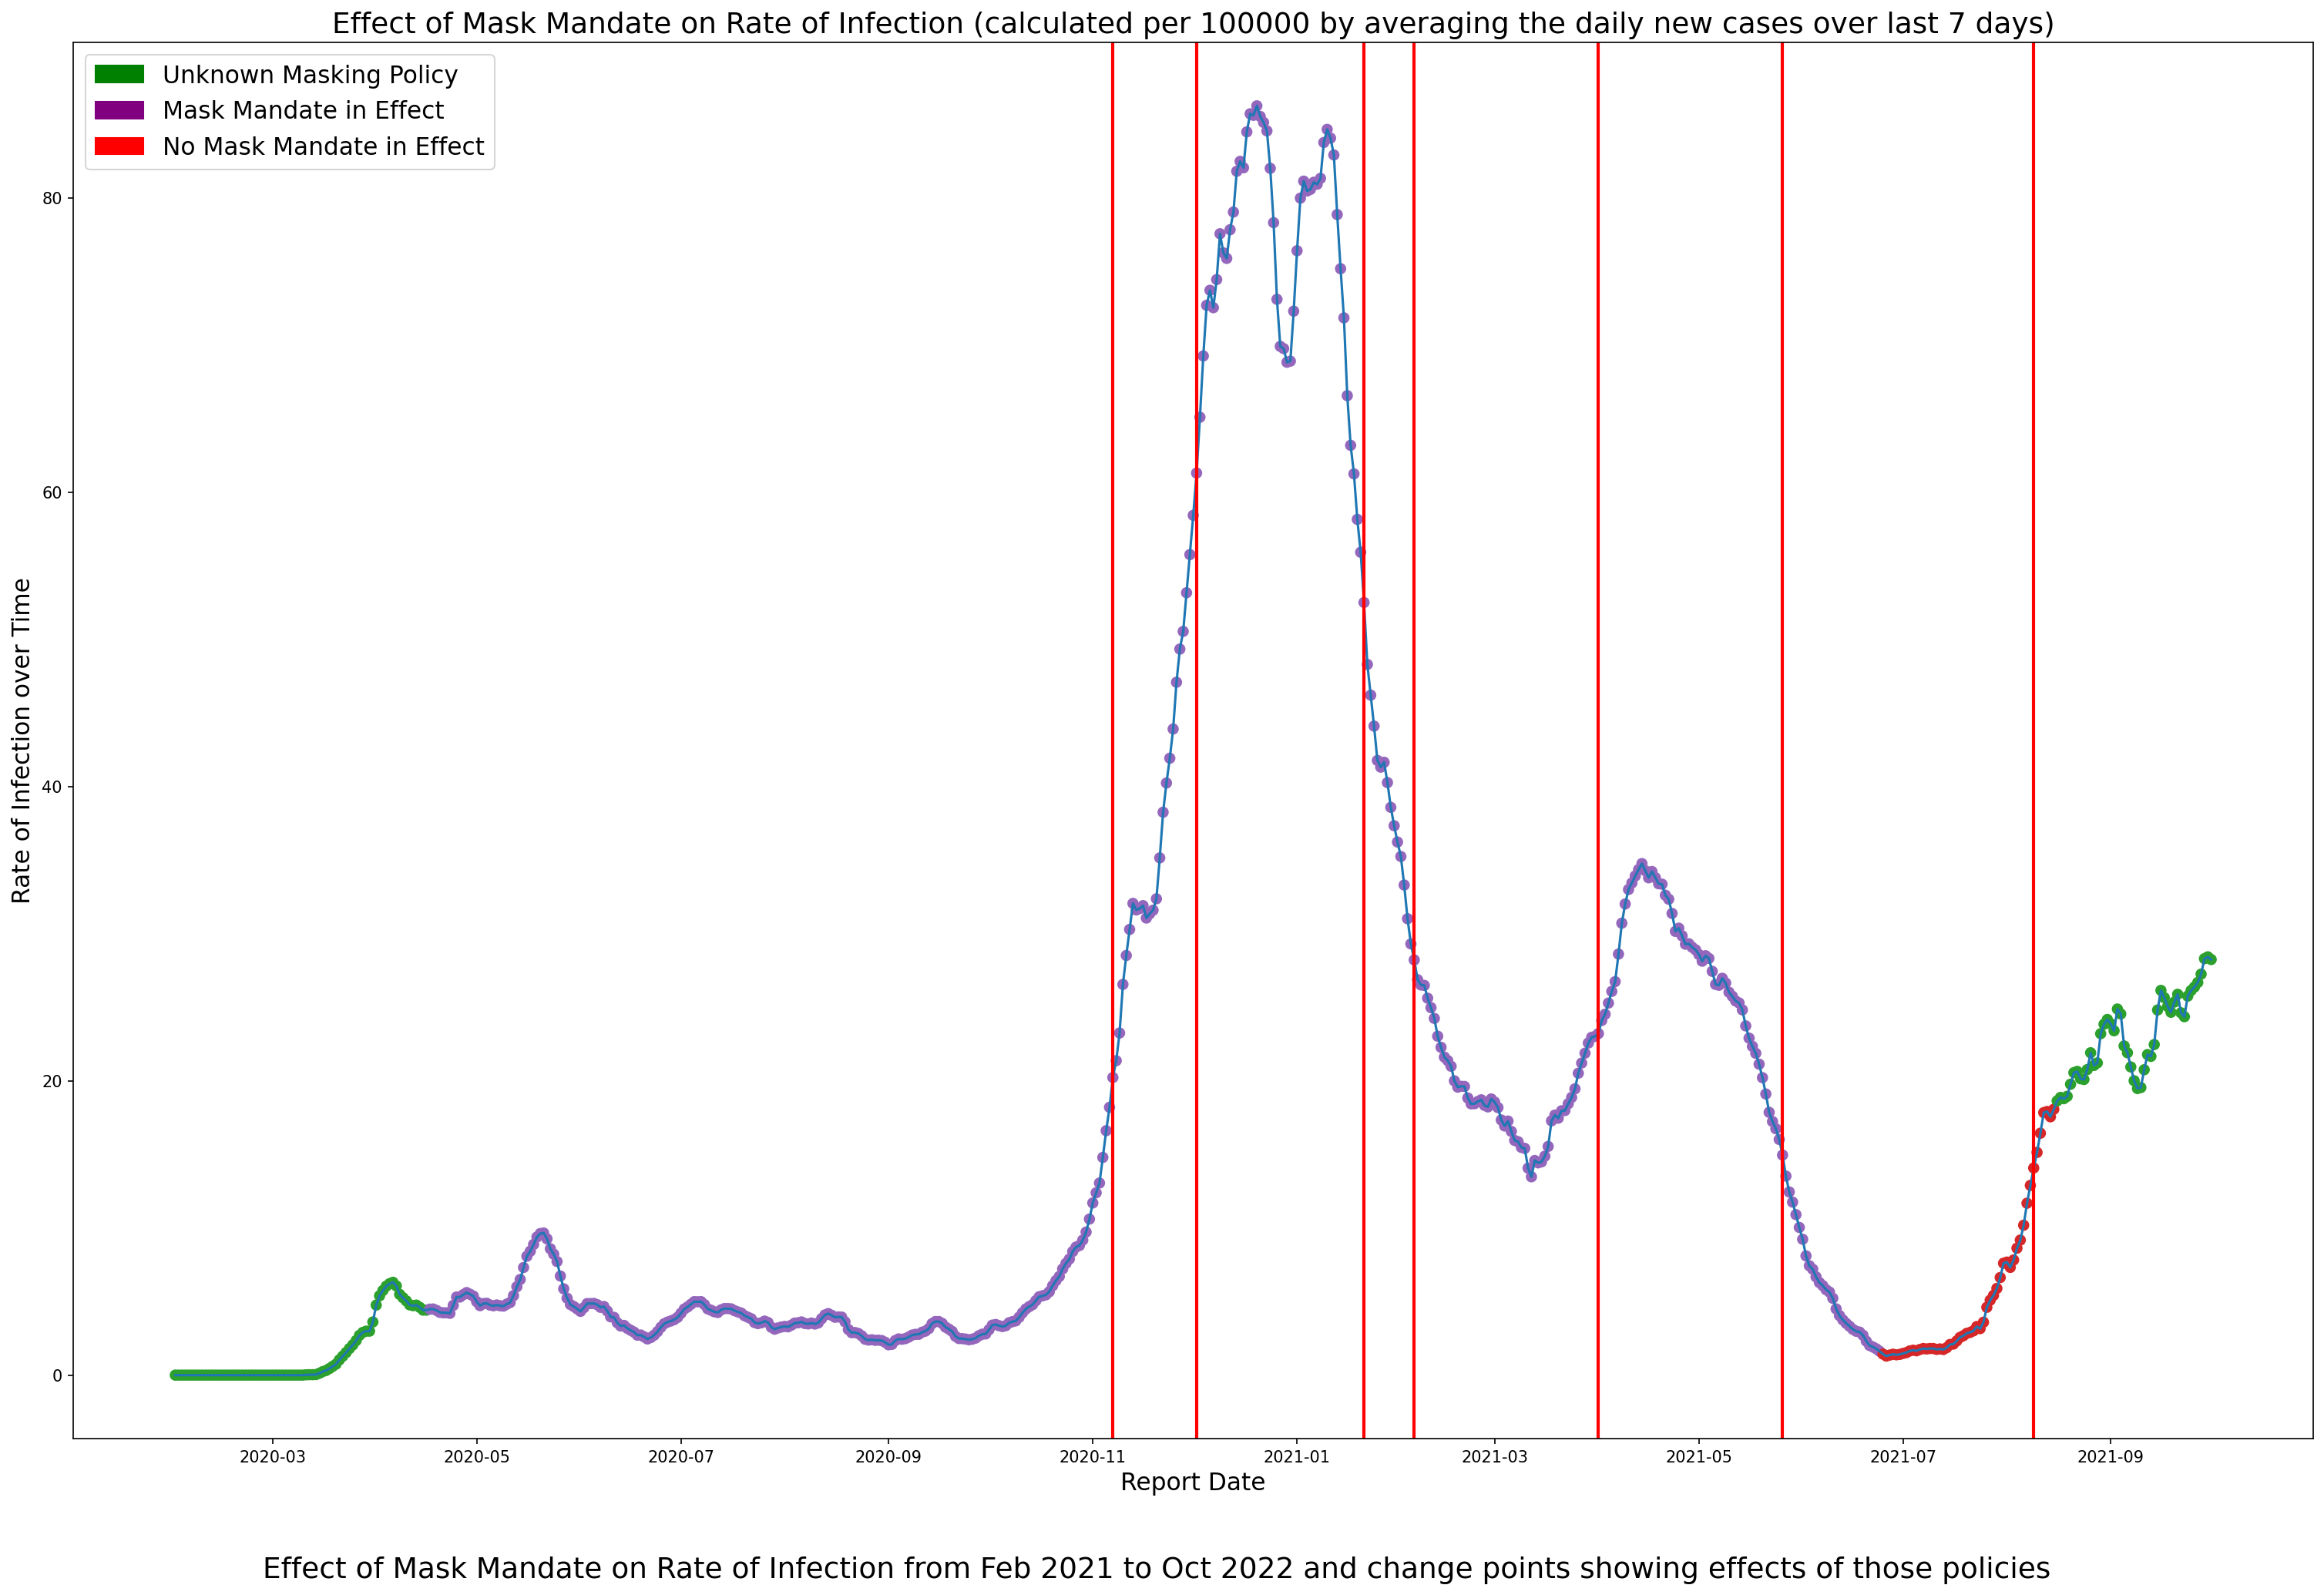

In [77]:
data = np.array(monroe_confirmed_by_date_extract['rate_of_infection_new'])
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen = 10)
tmp = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]
change_location_index = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]

plt.figure(figsize=(25,16), dpi=150)
plt.scatter(cases_mandate_merge['date'], cases_mandate_merge['rate_of_infection_new'], c=cases_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.plot(cases_mandate_merge['date'], cases_mandate_merge['rate_of_infection_new'])

for x in change_location_index['date']:
    plt.axvline(x, lw=2, color='red')
plt.title('Effect of Mask Mandate on Rate of Infection (calculated per 100000 by averaging the daily new cases over last 7 days)', fontdict={'fontsize': 18})
plt.xlabel('Report Date', fontdict={'fontsize': 15})
plt.ylabel('Rate of Infection over Time', fontdict={'fontsize': 15})

plt.legend(handles=[green_patch, purple_patch, red_patch], prop={'size': 15}, loc=2)

txt="Effect of Mask Mandate on Rate of Infection from Feb 2021 to Oct 2022 and change points showing effects of those policies"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=18)



### Derivative of Rate of Infection

We define derivative of rate of infection as the change in rate of infection per unit time (= 1 day here)

In [66]:
cases_mandate_merge['rate_of_infection_derivative'] = (cases_mandate_merge['rate_of_infection_new'] - cases_mandate_merge.shift(periods = 1)['rate_of_infection_new'])
cases_mandate_merge['rate_of_infection_new'].fillna(0.0, inplace=True)

monroe_confirmed_by_date_extract['rate_of_infection_derivative'] = (monroe_confirmed_by_date_extract['rate_of_infection_new'] - monroe_confirmed_by_date_extract.shift(periods = 1)['rate_of_infection_new'])
monroe_confirmed_by_date_extract['rate_of_infection_new'].fillna(0.0, inplace=True)


<ipython-input-66-3081c731981e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monroe_confirmed_by_date_extract['rate_of_infection_derivative'] = (monroe_confirmed_by_date_extract['rate_of_infection_new'] - monroe_confirmed_by_date_extract.shift(periods = 1)['rate_of_infection_new'])
/Users/aqua/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Text(0.5, 0.06, 'Derivative of daily Rate of Infection from Feb 2021 to Oct 2022 along with masking policies and change points showing effects of those policies')

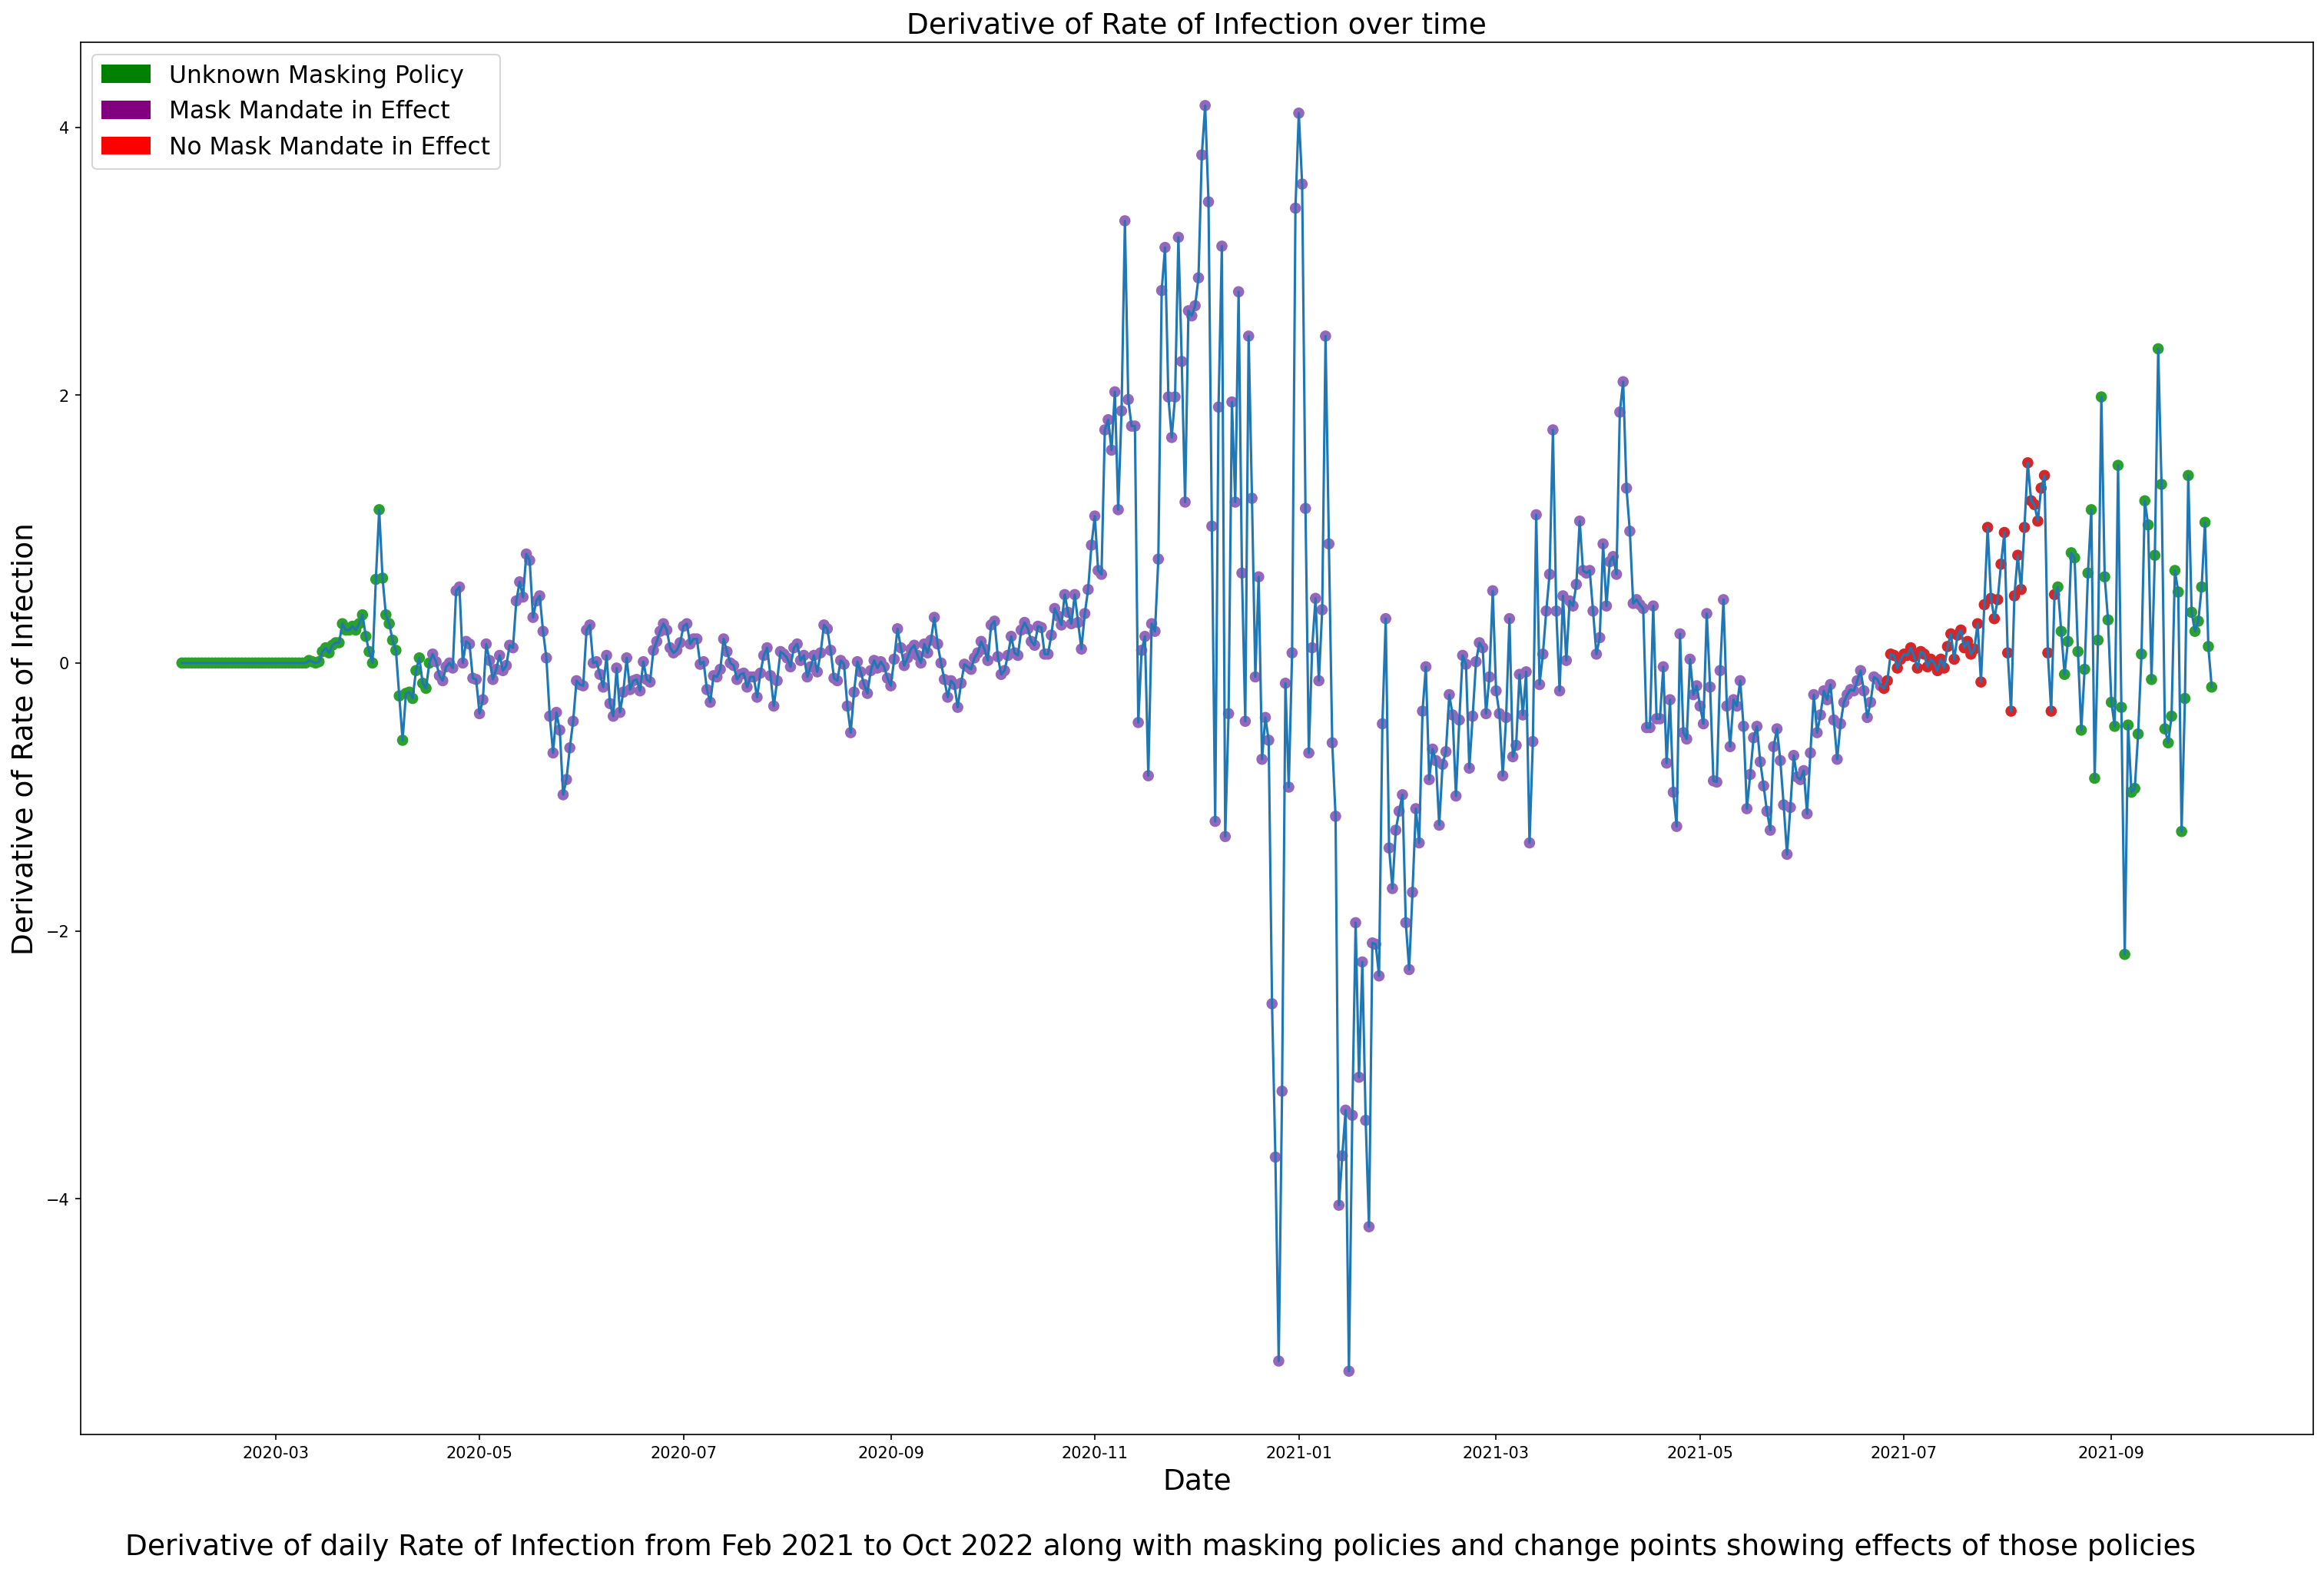

In [78]:
data = np.array(monroe_confirmed_by_date_extract['rate_of_infection_derivative'])
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen = 10)
tmp = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]
change_location_index = monroe_confirmed_by_date_extract.iloc[change_location1[:-1]]

plt.figure(figsize=(25,16), dpi=150)
plt.scatter(cases_mandate_merge['date'], cases_mandate_merge['rate_of_infection_derivative'], c=cases_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.plot(cases_mandate_merge['date'], cases_mandate_merge['rate_of_infection_derivative'])


plt.xlabel('Date', fontdict={'fontsize': 18})
plt.ylabel('Derivative of Rate of Infection', fontdict={'fontsize': 18})
plt.title('Derivative of Rate of Infection over time', fontdict={'fontsize': 18})

plt.legend(handles=[green_patch, purple_patch, red_patch], prop={'size': 15}, loc=2)

txt="Derivative of daily Rate of Infection from Feb 2021 to Oct 2022 along with masking policies and change points showing effects of those policies"
plt.figtext(0.5, 0.06, txt, wrap=True, horizontalalignment='center', fontsize=18)


### Tranforming data for Death Metrics for Analysis

To perform more analysis on the data, we also take a look at death metrics. We see the daily death count change, and the effect of masking policies on this count

In [35]:
raw_monroe_deaths = raw_us_deaths[(raw_us_deaths["Province_State"] == "New York") & (raw_us_deaths["Admin2"] == "Monroe")]
monroe_death_by_date = raw_monroe_deaths[raw_monroe_deaths.columns[12:]]
monroe_death_by_date = pd.DataFrame(monroe_death_by_date.iloc[0])
monroe_death_by_date = monroe_death_by_date.reset_index()
monroe_death_by_date.columns = ["date", "deaths"]
monroe_death_by_date["date"] = pd.to_datetime(monroe_death_by_date["date"])
monroe_death_by_date["death_rate"] = pd.Series(np.gradient(monroe_death_by_date["deaths"]), monroe_death_by_date["date"], name='death_cases_rate').values


In [36]:
monroe_death_by_date_extract = monroe_death_by_date.iloc[10:619]
monroe_death_by_date_extract.head()

,date,deaths,death_rate
10,2020-02-01,0,0.0
11,2020-02-02,0,0.0
12,2020-02-03,0,0.0
13,2020-02-04,0,0.0
14,2020-02-05,0,0.0


Text(0, 0.5, 'Deaths Rate')

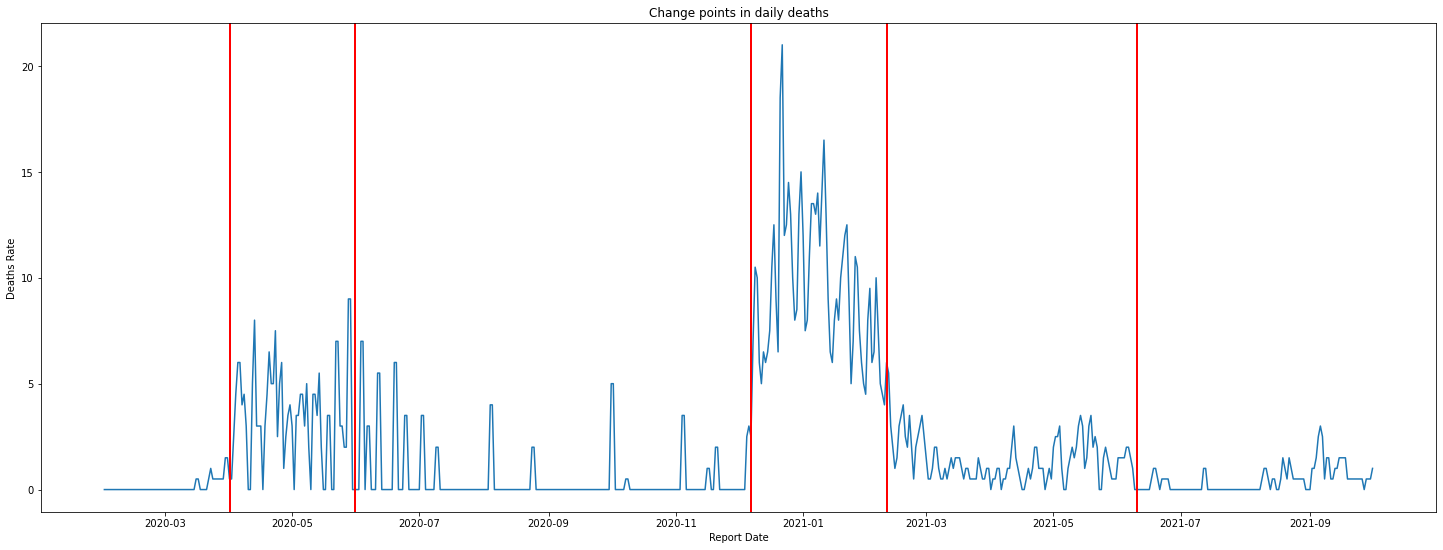

In [39]:
data = np.array(monroe_death_by_date_extract['death_rate'])
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen = 10)
tmp = monroe_death_by_date_extract.iloc[change_location1[:-1]]
change_location_index = monroe_death_by_date_extract.iloc[change_location1[:-1]]

plt.figure(figsize=(25,9))
plt.plot(monroe_death_by_date_extract['date'], monroe_death_by_date_extract['death_rate'])
for x in change_location_index['date']:
    plt.axvline(x, lw=2, color='red')
plt.title('Change points in daily deaths')
plt.xlabel('Report Date')
plt.ylabel('Deaths Rate')

In [38]:
deaths_mandate_merge = pd.merge(monroe_death_by_date_extract, monroe_mask_mandates_april_2020_aug_2021, on="date", how='left')


In [41]:
deaths_mandate_merge["Face_Masks_Required_in_Public"] = deaths_mandate_merge["Face_Masks_Required_in_Public"].fillna("No Data")


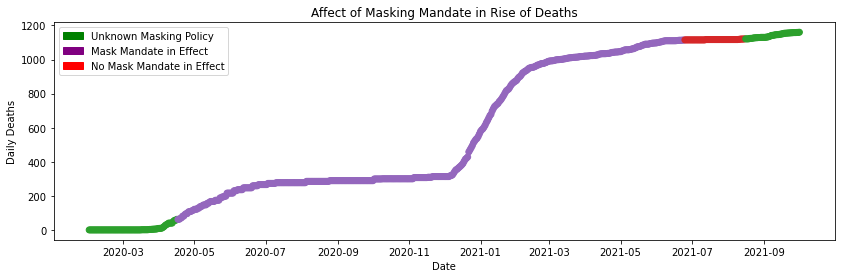

In [42]:
plt.figure(figsize=(14,4))
df_plot = plt.scatter(deaths_mandate_merge['date'], deaths_mandate_merge['deaths'], c=deaths_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
plt.title('Affect of Masking Mandate in Rise of Deaths')

green_patch = mpatches.Patch(color='green', label='Unknown Masking Policy')
purple_patch = mpatches.Patch(color='purple', label='Mask Mandate in Effect')
red_patch = mpatches.Patch(color='red', label='No Mask Mandate in Effect')

plt.legend(handles=[green_patch, purple_patch, red_patch])


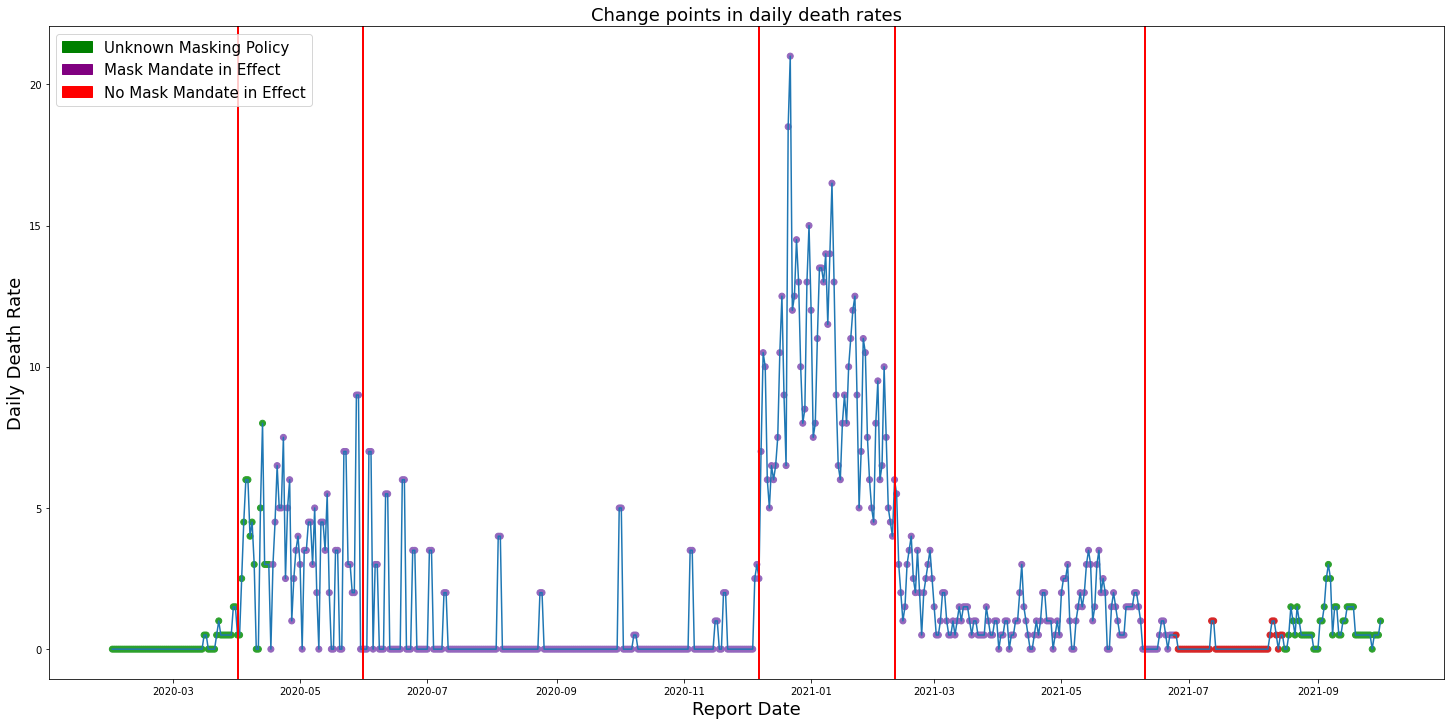

In [79]:
data = np.array(monroe_death_by_date_extract['death_rate'])
algo1 = rpt.Pelt(model="rbf").fit(data)
change_location1 = algo1.predict(pen = 10)
tmp = monroe_death_by_date_extract.iloc[change_location1[:-1]]
change_location_index = monroe_death_by_date_extract.iloc[change_location1[:-1]]

plt.figure(figsize=(25,12))
plt.scatter(deaths_mandate_merge['date'], deaths_mandate_merge['death_rate'], c=deaths_mandate_merge['Face_Masks_Required_in_Public'].map(colors))
plt.plot(deaths_mandate_merge['date'], deaths_mandate_merge['death_rate'])

for x in change_location_index['date']:
    plt.axvline(x, lw=2, color='red')
plt.title('Change points in daily death rates', fontdict={'fontsize': 18})
plt.xlabel('Report Date', fontdict={'fontsize': 18})
plt.ylabel('Daily Death Rate', fontdict={'fontsize': 18})

plt.legend(handles=[green_patch, purple_patch, red_patch], prop={'size': 15}, loc=2)
